Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-13-261513b1edd8>:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trial_store['DATE'] = trial_store['DATE'].astype(str)
<ipython-input-13-261513b1edd8>:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control_store['DATE'] = control_store['DATE'].astype(str)


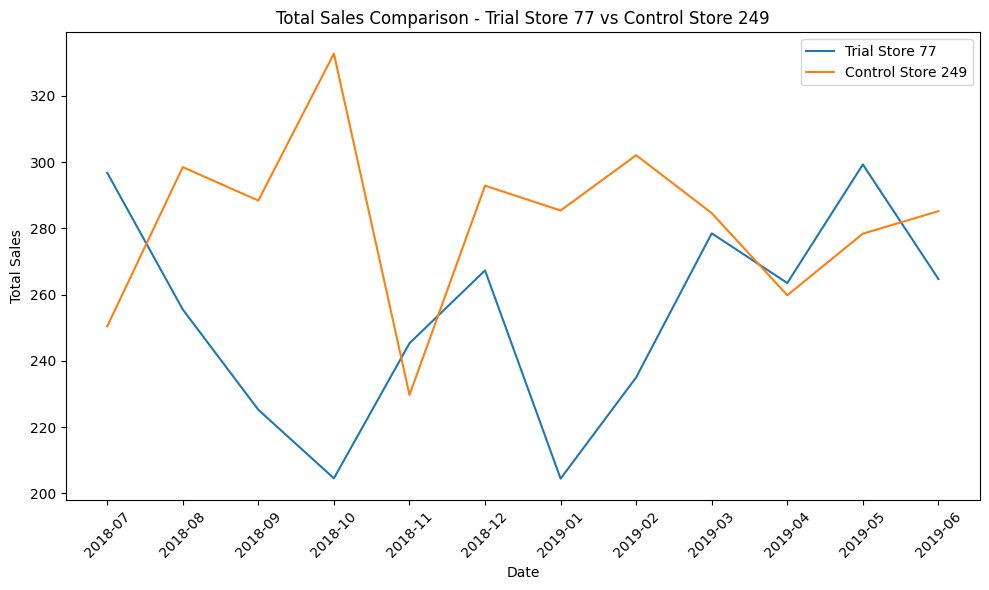

<ipython-input-13-261513b1edd8>:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trial_store['DATE'] = trial_store['DATE'].astype(str)
<ipython-input-13-261513b1edd8>:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control_store['DATE'] = control_store['DATE'].astype(str)


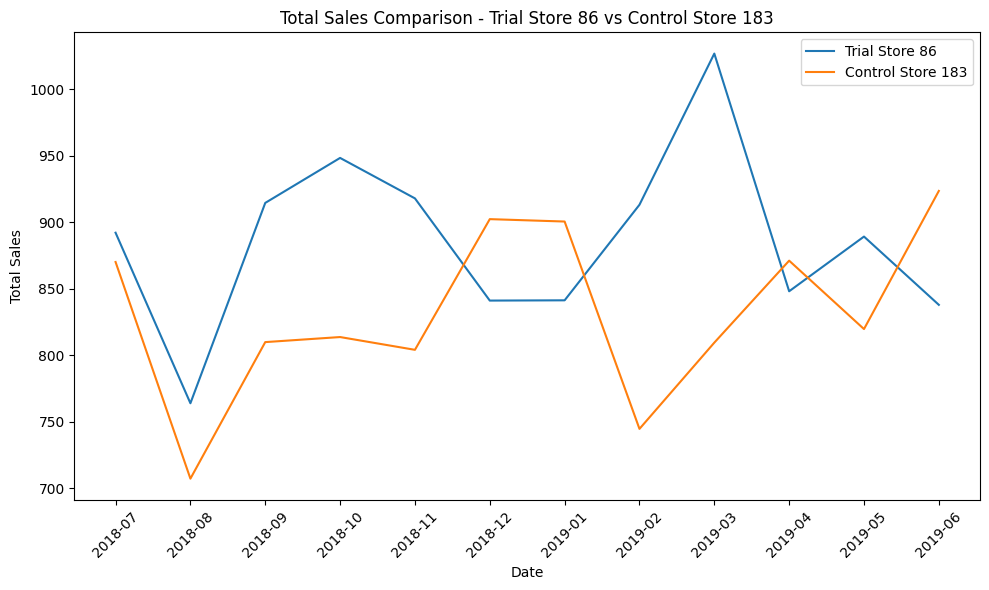

<ipython-input-13-261513b1edd8>:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trial_store['DATE'] = trial_store['DATE'].astype(str)
<ipython-input-13-261513b1edd8>:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control_store['DATE'] = control_store['DATE'].astype(str)


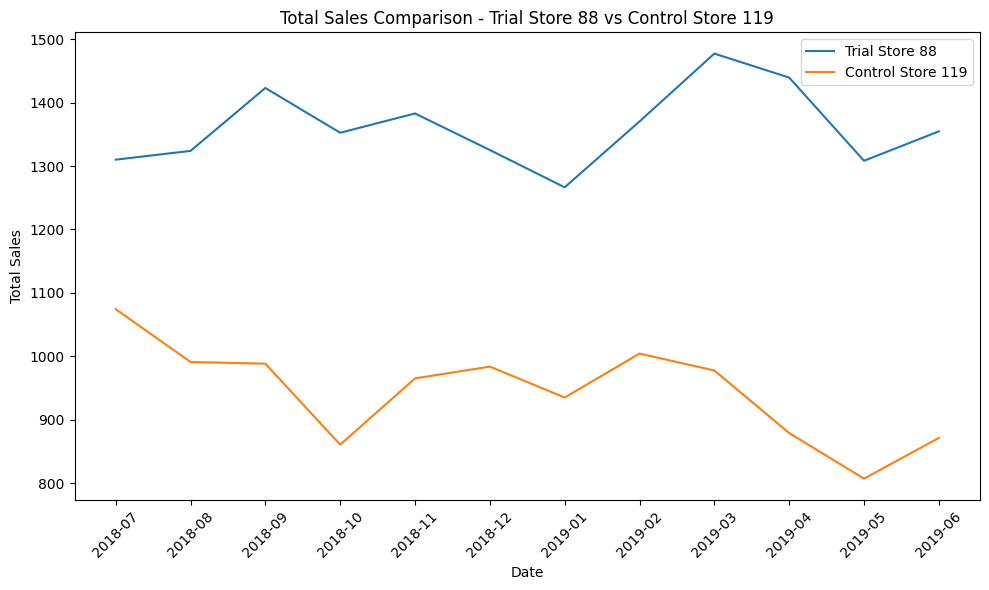

In [13]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have already mounted Google Drive and loaded your data
# Mount Google Drive
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')    # Uncomment if running in Google Colab

# Replace with actual dataset loading code
data = pd.read_csv('/content/drive/MyDrive/Pythonclass/QVI_data.csv')

# Convert the date column to datetime format
data['DATE'] = pd.to_datetime(data['DATE'], errors='coerce')

# Filter data for trial stores 77, 86, and 88
trial_stores = data[data['STORE_NBR'].isin([77, 86, 88])]

# Function to calculate metrics
def calculate_metrics(data):
    metrics = data.groupby(['STORE_NBR', data['DATE'].dt.to_period('M')]).agg({
        'TOT_SALES': 'sum',
        'LYLTY_CARD_NBR': pd.Series.nunique,
        'TXN_ID': 'count'
    }).reset_index()
    metrics['Avg_Transactions_Per_Customer'] = metrics['TXN_ID'] / metrics['LYLTY_CARD_NBR']
    return metrics.rename(columns={'TOT_SALES': 'Total_Sales', 'LYLTY_CARD_NBR': 'Total_Customers'})

# Calculate metrics for trial stores
trial_metrics = calculate_metrics(trial_stores)

# Function to calculate metrics for control stores
def calculate_control_metrics(data):
    control_metrics = data.groupby(['STORE_NBR', data['DATE'].dt.to_period('M')]).agg({
        'TOT_SALES': 'sum',
        'LYLTY_CARD_NBR': pd.Series.nunique,
        'TXN_ID': 'count'
    }).reset_index()
    control_metrics['Avg_Transactions_Per_Customer'] = control_metrics['TXN_ID'] / control_metrics['LYLTY_CARD_NBR']
    return control_metrics.rename(columns={'TOT_SALES': 'Total_Sales', 'LYLTY_CARD_NBR': 'Total_Customers'})

# Assuming control stores data excludes trial stores 77, 86, and 88
control_stores_data = data[~data['STORE_NBR'].isin([77, 86, 88])]
control_metrics = calculate_control_metrics(control_stores_data)

# Function to select control stores based on similarity
def select_control_stores(trial_metrics, control_metrics):
    control_stores = {}
    for store_id in trial_metrics['STORE_NBR'].unique():
        trial_data = trial_metrics[trial_metrics['STORE_NBR'] == store_id].iloc[:, 2:]  # Assuming metrics start from 3rd column
        correlations = []
        for control_store_id in control_metrics['STORE_NBR'].unique():
            control_data = control_metrics[control_metrics['STORE_NBR'] == control_store_id].iloc[:, 2:]  # Assuming metrics start from 3rd column

            # Ensure both trial_data and control_data have the same length
            min_length = min(len(trial_data), len(control_data))
            trial_data = trial_data.iloc[:min_length]
            control_data = control_data.iloc[:min_length]

            # Calculate Pearson correlation
            try:
                corr, _ = pearsonr(trial_data.values.flatten(), control_data.values.flatten())
                correlations.append((control_store_id, corr))
            except TypeError as e:
                print(f"Error calculating correlation: {e}")

        # Selecting control store with highest correlation
        control_stores[store_id] = max(correlations, key=lambda x: x[1])[0]

    return control_stores

# Select control stores for each trial store
control_store_mapping = select_control_stores(trial_metrics, control_metrics)

# Calculate metrics for control stores
control_metrics = calculate_metrics(control_stores_data)

# Plotting for each trial-control pair
for trial_store_id in [77, 86, 88]:
    trial_store = trial_metrics[trial_metrics['STORE_NBR'] == trial_store_id]
    control_store_id = control_store_mapping[trial_store_id]
    control_store = control_metrics[control_metrics['STORE_NBR'] == control_store_id]

    # Convert 'DATE' to string format
    trial_store['DATE'] = trial_store['DATE'].astype(str)
    control_store['DATE'] = control_store['DATE'].astype(str)

    # Plotting with Matplotlib
    plt.figure(figsize=(10, 6))
    plt.plot(trial_store['DATE'], trial_store['Total_Sales'], label=f'Trial Store {trial_store_id}')
    plt.plot(control_store['DATE'], control_store['Total_Sales'], label=f'Control Store {control_store_id}')
    plt.title(f'Total Sales Comparison - Trial Store {trial_store_id} vs Control Store {control_store_id}')
    plt.xlabel('Date')
    plt.ylabel('Total Sales')
    plt.legend()
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()


Mounted at /content/drive
Days with the largest vertical distance between a data point and the linear regression line:
    Day  Sunshine hours (hours per day)  Billiard club occupancy (%)  \
19   20                               3                           47   
11   12                               5                           70   
42   43                               9                           52   

    Residuals  
19  21.052308  
11   9.935652  
42   7.911572  


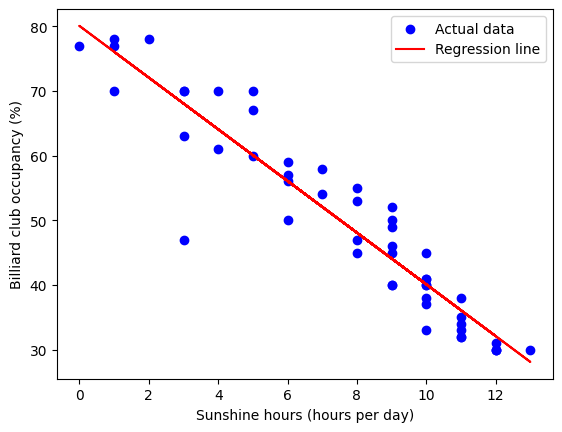

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Load the data
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')    # Uncomment if running in Google Colab

# Replace with actual dataset loading code

data = pd.read_csv('/content/drive/MyDrive/Pythonclass/measurements.csv')

# Extract the variables
X = data['Sunshine hours (hours per day)'].values.reshape(-1, 1)
y = data['Billiard club occupancy (%)'].values

# Fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Predict the values
y_pred = model.predict(X)

# Calculate the residuals
residuals = np.abs(y - y_pred)

# Add the residuals to the dataframe
data['Residuals'] = residuals

# Find the top 3 days with the largest residuals
top_3_days = data.nlargest(3, 'Residuals')

# Print the results
print("Days with the largest vertical distance between a data point and the linear regression line:")
print(top_3_days[['Day', 'Sunshine hours (hours per day)', 'Billiard club occupancy (%)', 'Residuals']])

# Plotting the data and the regression line
plt.scatter(X, y, color='blue', label='Actual data')
plt.plot(X, y_pred, color='red', label='Regression line')
plt.xlabel('Sunshine hours (hours per day)')
plt.ylabel('Billiard club occupancy (%)')
plt.legend()
plt.show()
